# Seurat Clustering of bcd-RNAi data

In [1]:
#load packages
library(ggplot2)
library(magrittr)
library(data.table)
library(Seurat)
library(Matrix)
library(dplyr)
library(RColorBrewer)
library(MAST)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
 

In [2]:
count.table <- read.csv(file = '../../data/original_data/bcdRNAi/umi_count_table_HQC_bcdRNAi.csv')
head(count.table)
dim(count.table)

AAACCCAAGTGGTTCT AAACCCACAAGACCTT AAACCCACATGGAATA
Myo81F         0                0                0               
CR41571        0                0                0               
CR12798        0                0                0               
lncRNA:CR46123 0                0                0               
lncRNA:CR46122 0                0                0               
CR40182        0                0                0               
               AAACCCAGTTGTGGAG AAACCCATCACAGAGG AAACCCATCTGGGTCG
Myo81F         0                0                0               
CR41571        0                0                0               
CR12798        0                0                0               
lncRNA:CR46123 0                0                0               
lncRNA:CR46122 0                0                0               
CR40182        0                0                0               
               AAACGAAAGTCGAATA AAACGAACACTAAACC AAACGAACAGCTGAGA
Myo81F         0                0                0               
CR41571        0                0                0               
CR12798        0                0                0               
lncRNA:CR46123 0                0                0               
lncRNA:CR46122 0                0                0               
CR40182        0                0                0               
               AAACGAACAGGCTTGC ⋯ TTTGTTGCATTGTCGA TTTGTTGGTAGAGTTA
Myo81F         0                ⋯ 0                0               
CR41571        0                ⋯ 0                0               
CR12798        0                ⋯ 0                0               
lncRNA:CR46123 0                ⋯ 0                0               
lncRNA:CR46122 0                ⋯ 0                0               
CR40182        0                ⋯ 0                0               
               TTTGTTGGTCCGTACG TTTGTTGGTGCCCGTA TTTGTTGGTTCACGAT
Myo81F         0                0                0               
CR41571        0                0                0               
CR12798        0                0                0               
lncRNA:CR46123 0                0                0               
lncRNA:CR46122 0                0                0               
CR40182        0                0                0               
               TTTGTTGGTTTGAACC TTTGTTGTCCATGCAA TTTGTTGTCGTCGCTT
Myo81F         0                0                0               
CR41571        0                0                0               
CR12798        0                0                0               
lncRNA:CR46123 0                0                0               
lncRNA:CR46122 0                0                0               
CR40182        0                0                0               
               TTTGTTGTCTCGCTCA TTTGTTGTCTCGGTAA
Myo81F         0                0               
CR41571        0                0               
CR12798        0                0               
lncRNA:CR46123 0                0               
lncRNA:CR46122 0                0               
CR40182        0                0

[1] 17504  9223

In [3]:
seu_HQC <- CreateSeuratObject(count.table) 
seu_HQC

An object of class Seurat 
17504 features across 9223 samples within 1 assay 
Active assay: RNA (17504 features, 0 variable features)

In [4]:
is.mt <- grepl(pattern = '^mt:', x = row.names(seu_HQC))
is.rRNA <- grepl(pattern = 'rRNA', x = row.names(seu_HQC))
is.rRNA <- is.rRNA & (!is.mt)
mt.list <- row.names(seu_HQC)[is.mt]
rRNA.list <- row.names(seu_HQC)[is.rRNA]

In [5]:
head(rRNA.list)

[1] "5SrRNA:CR33452" "5SrRNA:CR33451" "5SrRNA:CR33450" "5SrRNA:CR33449"
[5] "5SrRNA:CR33448" "5SrRNA:CR33447"

In [6]:
seu_HQC[["percent.mt"]] <- PercentageFeatureSet(seu_HQC, pattern = "^mt:")
seu_HQC[["percent.rRNA"]] <- PercentageFeatureSet(seu_HQC, features = rRNA.list)

In [7]:
summary(seu_HQC$percent.mt)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.03125  4.03646  5.24175  5.10592  6.15604 11.02738 

In [8]:
summary(seu_HQC$percent.rRNA)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2396  0.6480  0.8691  1.0736  1.2665  4.1724 

## Normalize, DR and Clustering

In [9]:
seu_HQC <- suppressWarnings(SCTransform(seu_HQC, vars.to.regress = c("percent.mt", "percent.rRNA"), verbose = FALSE)) 

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


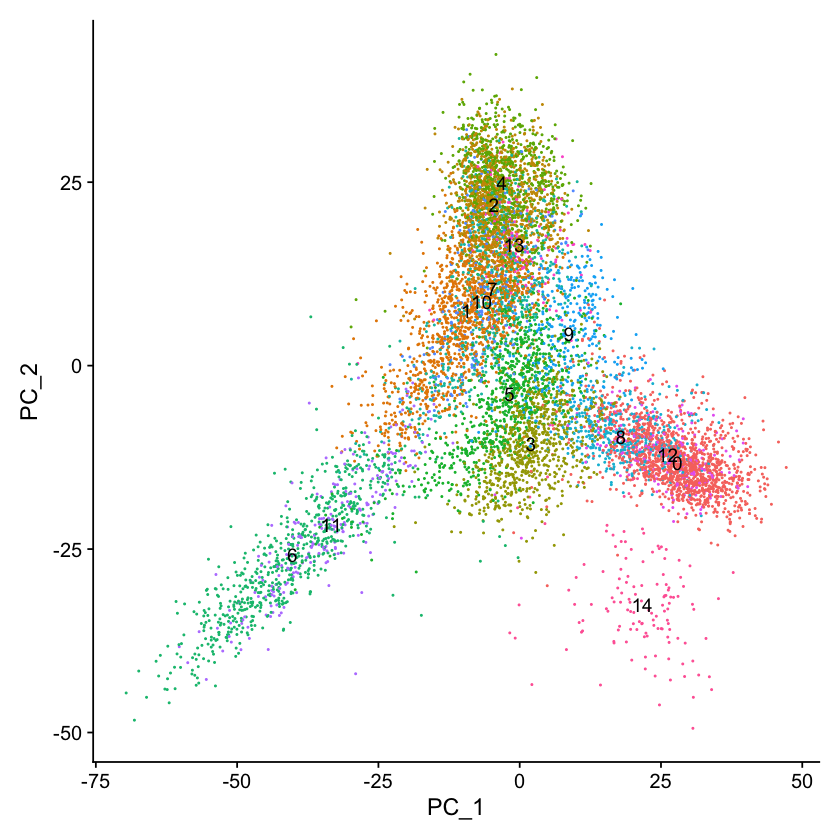

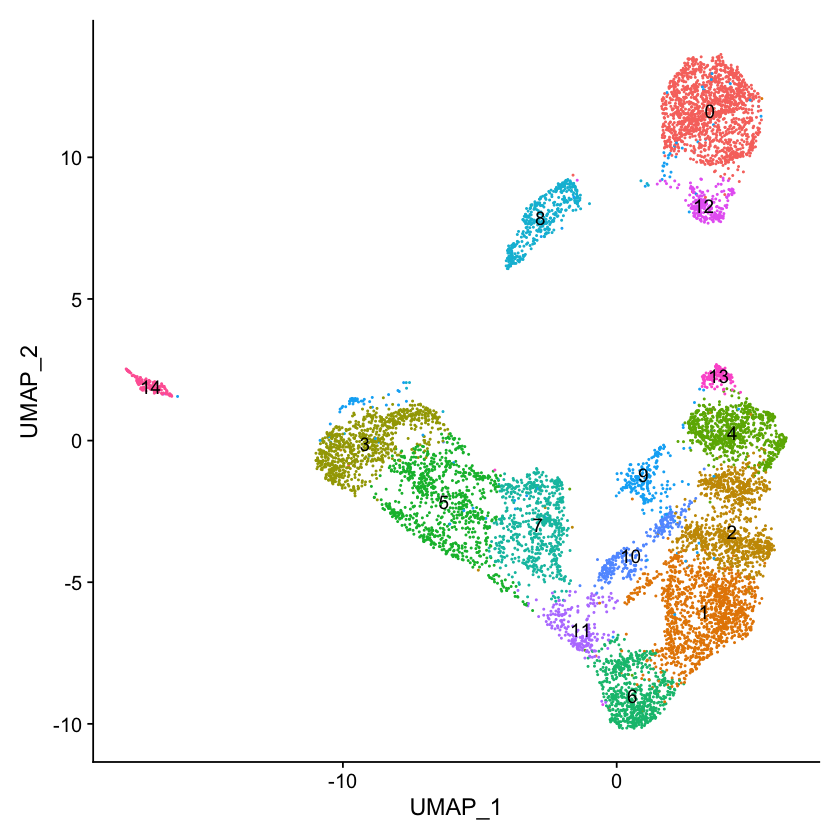

In [10]:
seu_HQC <- RunPCA(seu_HQC, verbose = FALSE)
seu_HQC <- RunUMAP(seu_HQC, dims = 1:30, verbose = FALSE, n.neighbors = 20L)
seu_HQC <- FindNeighbors(seu_HQC, dims = 1:30, verbose = FALSE)
seu_HQC <- FindClusters(seu_HQC, verbose = FALSE)
DimPlot(seu_HQC, reduction =  "pca", label = TRUE) + NoLegend()
DimPlot(seu_HQC, reduction =  "umap", label = TRUE) + NoLegend()

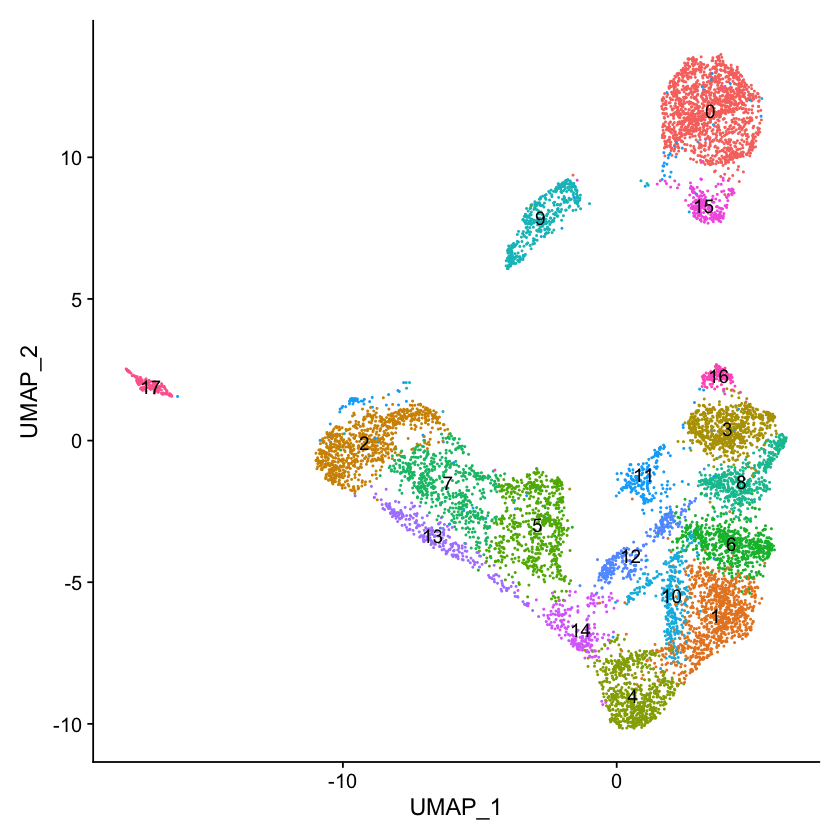

In [11]:
seu_HQC <- FindClusters(seu_HQC, verbose = FALSE, resolution=1)
DimPlot(seu_HQC, reduction =  "umap", label = TRUE) + NoLegend()

In [12]:
all.markers <- FindAllMarkers(object = seu_HQC, only.pos = TRUE)
all.markers.top10 <- all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17



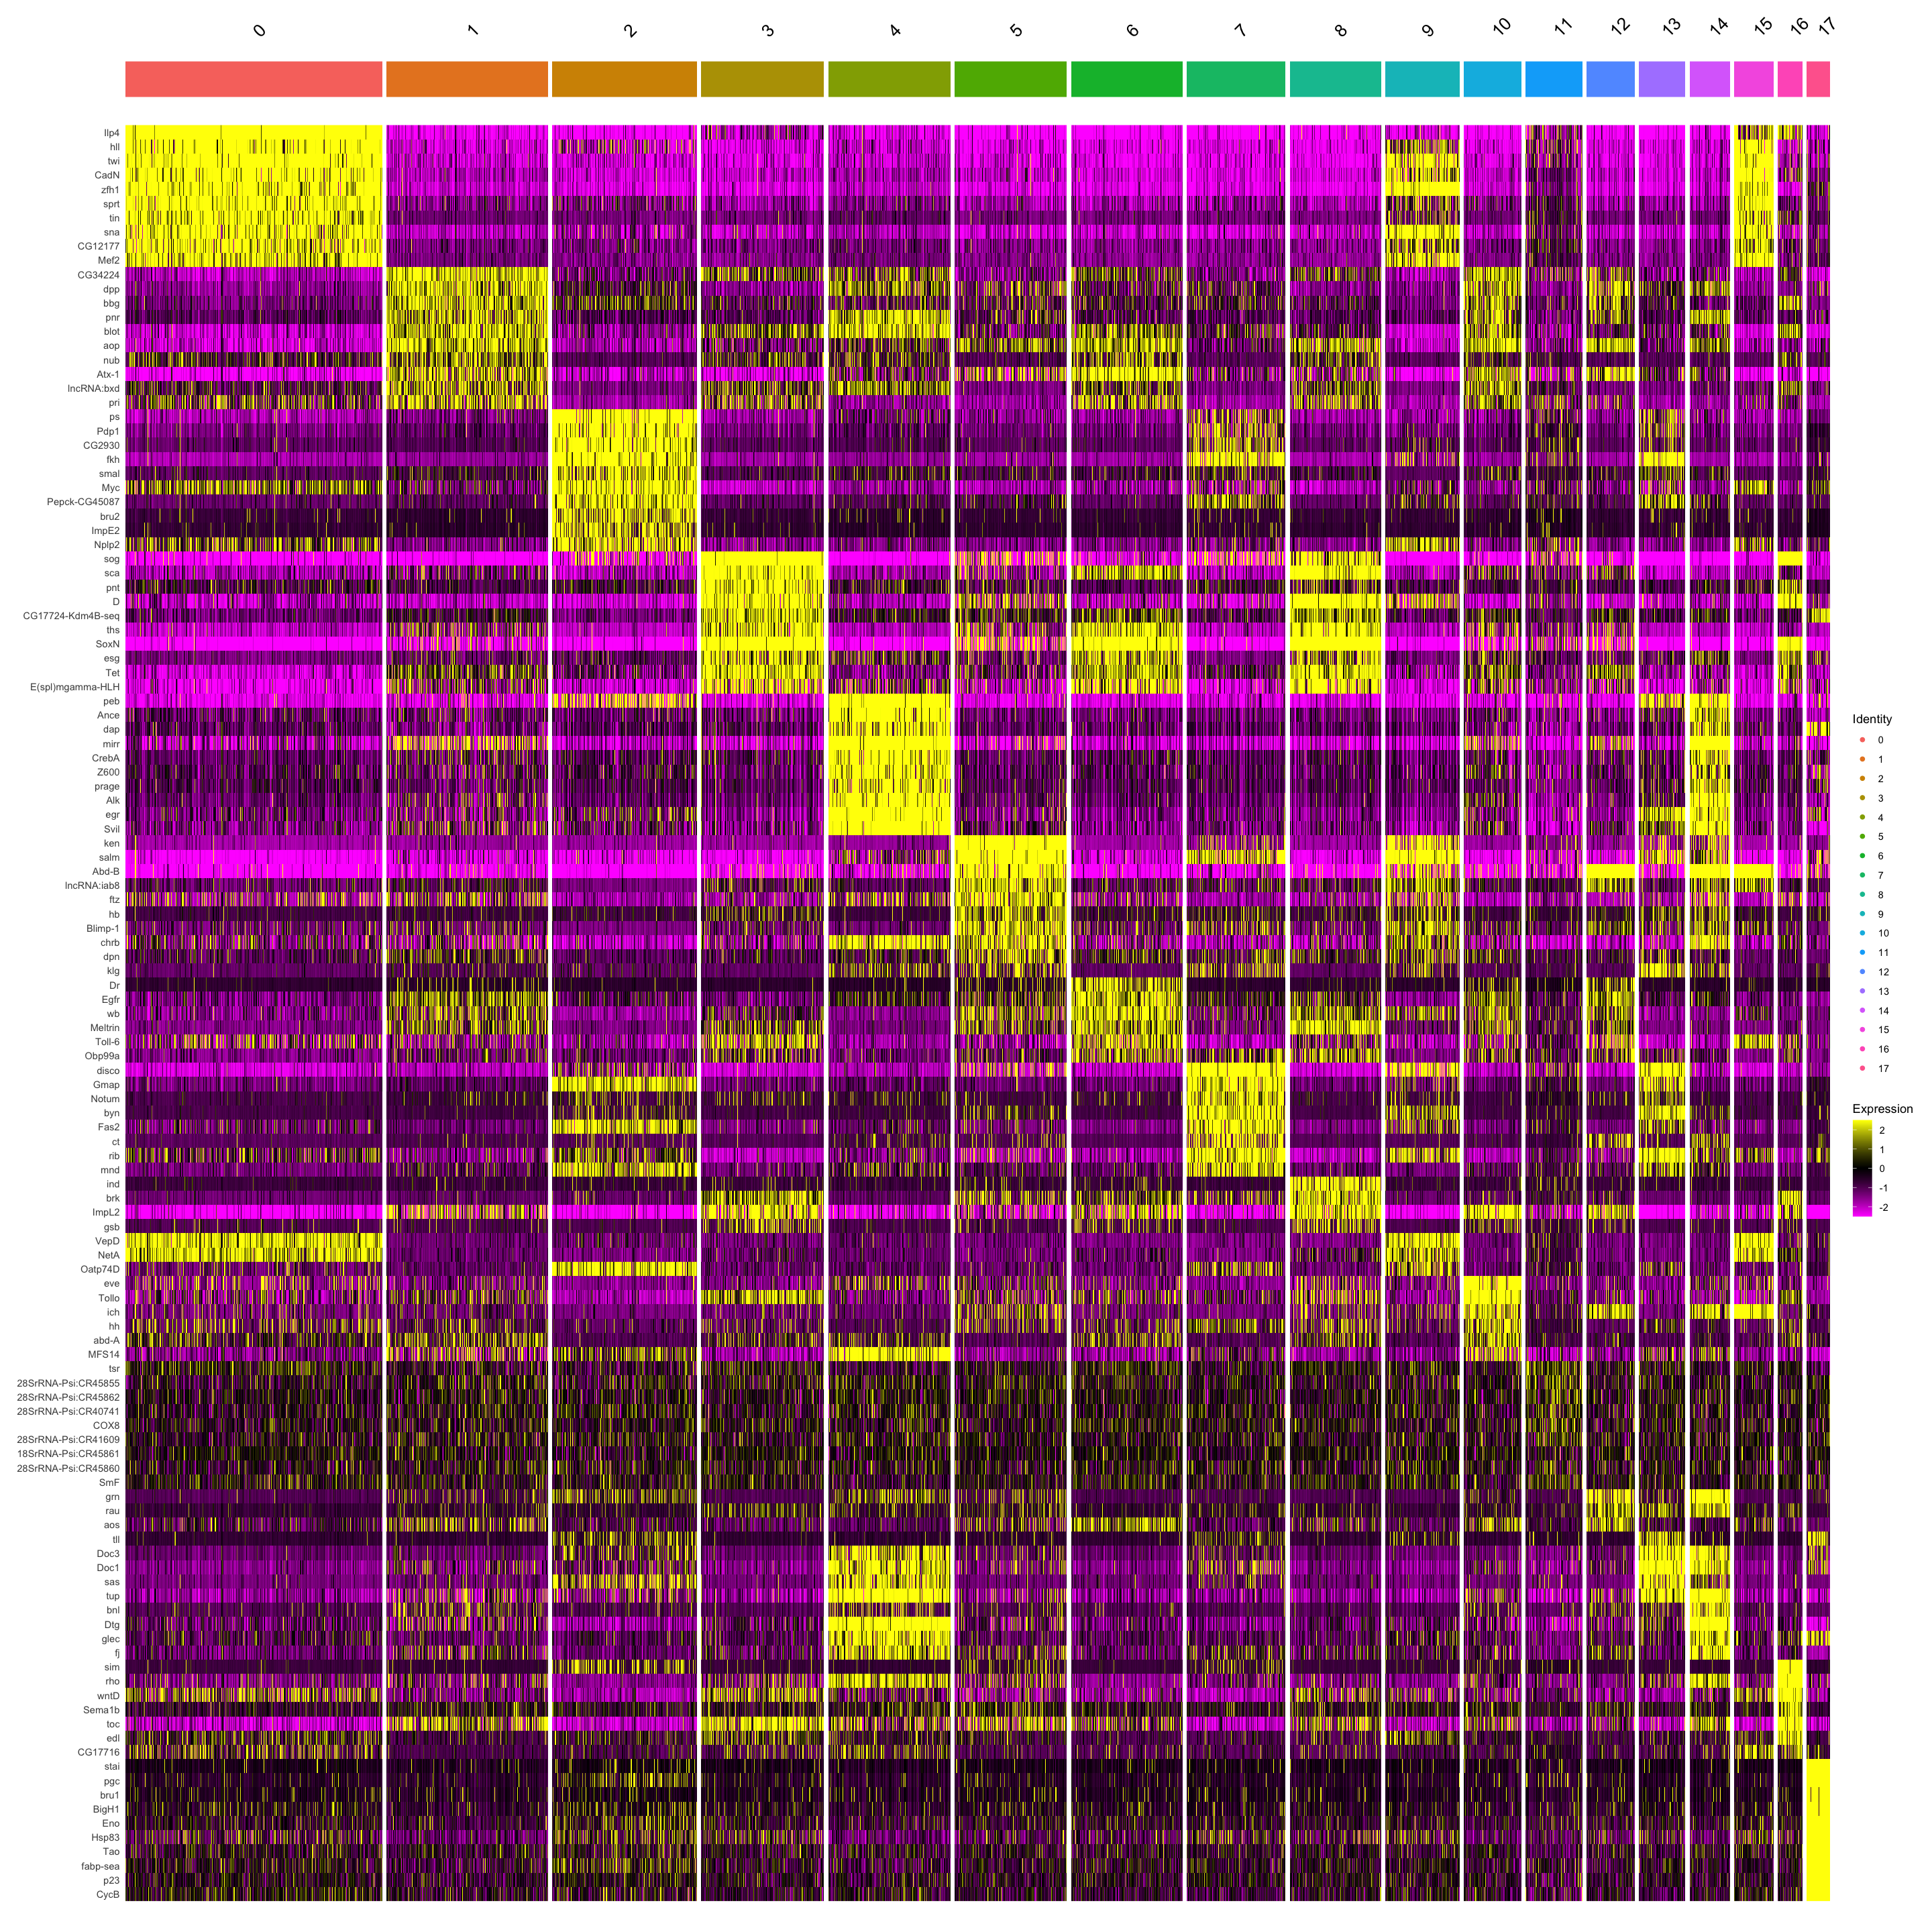

In [13]:
options(repr.plot.width=24, repr.plot.height=24)
DoHeatmap(seu_HQC, features = all.markers.top10$gene)

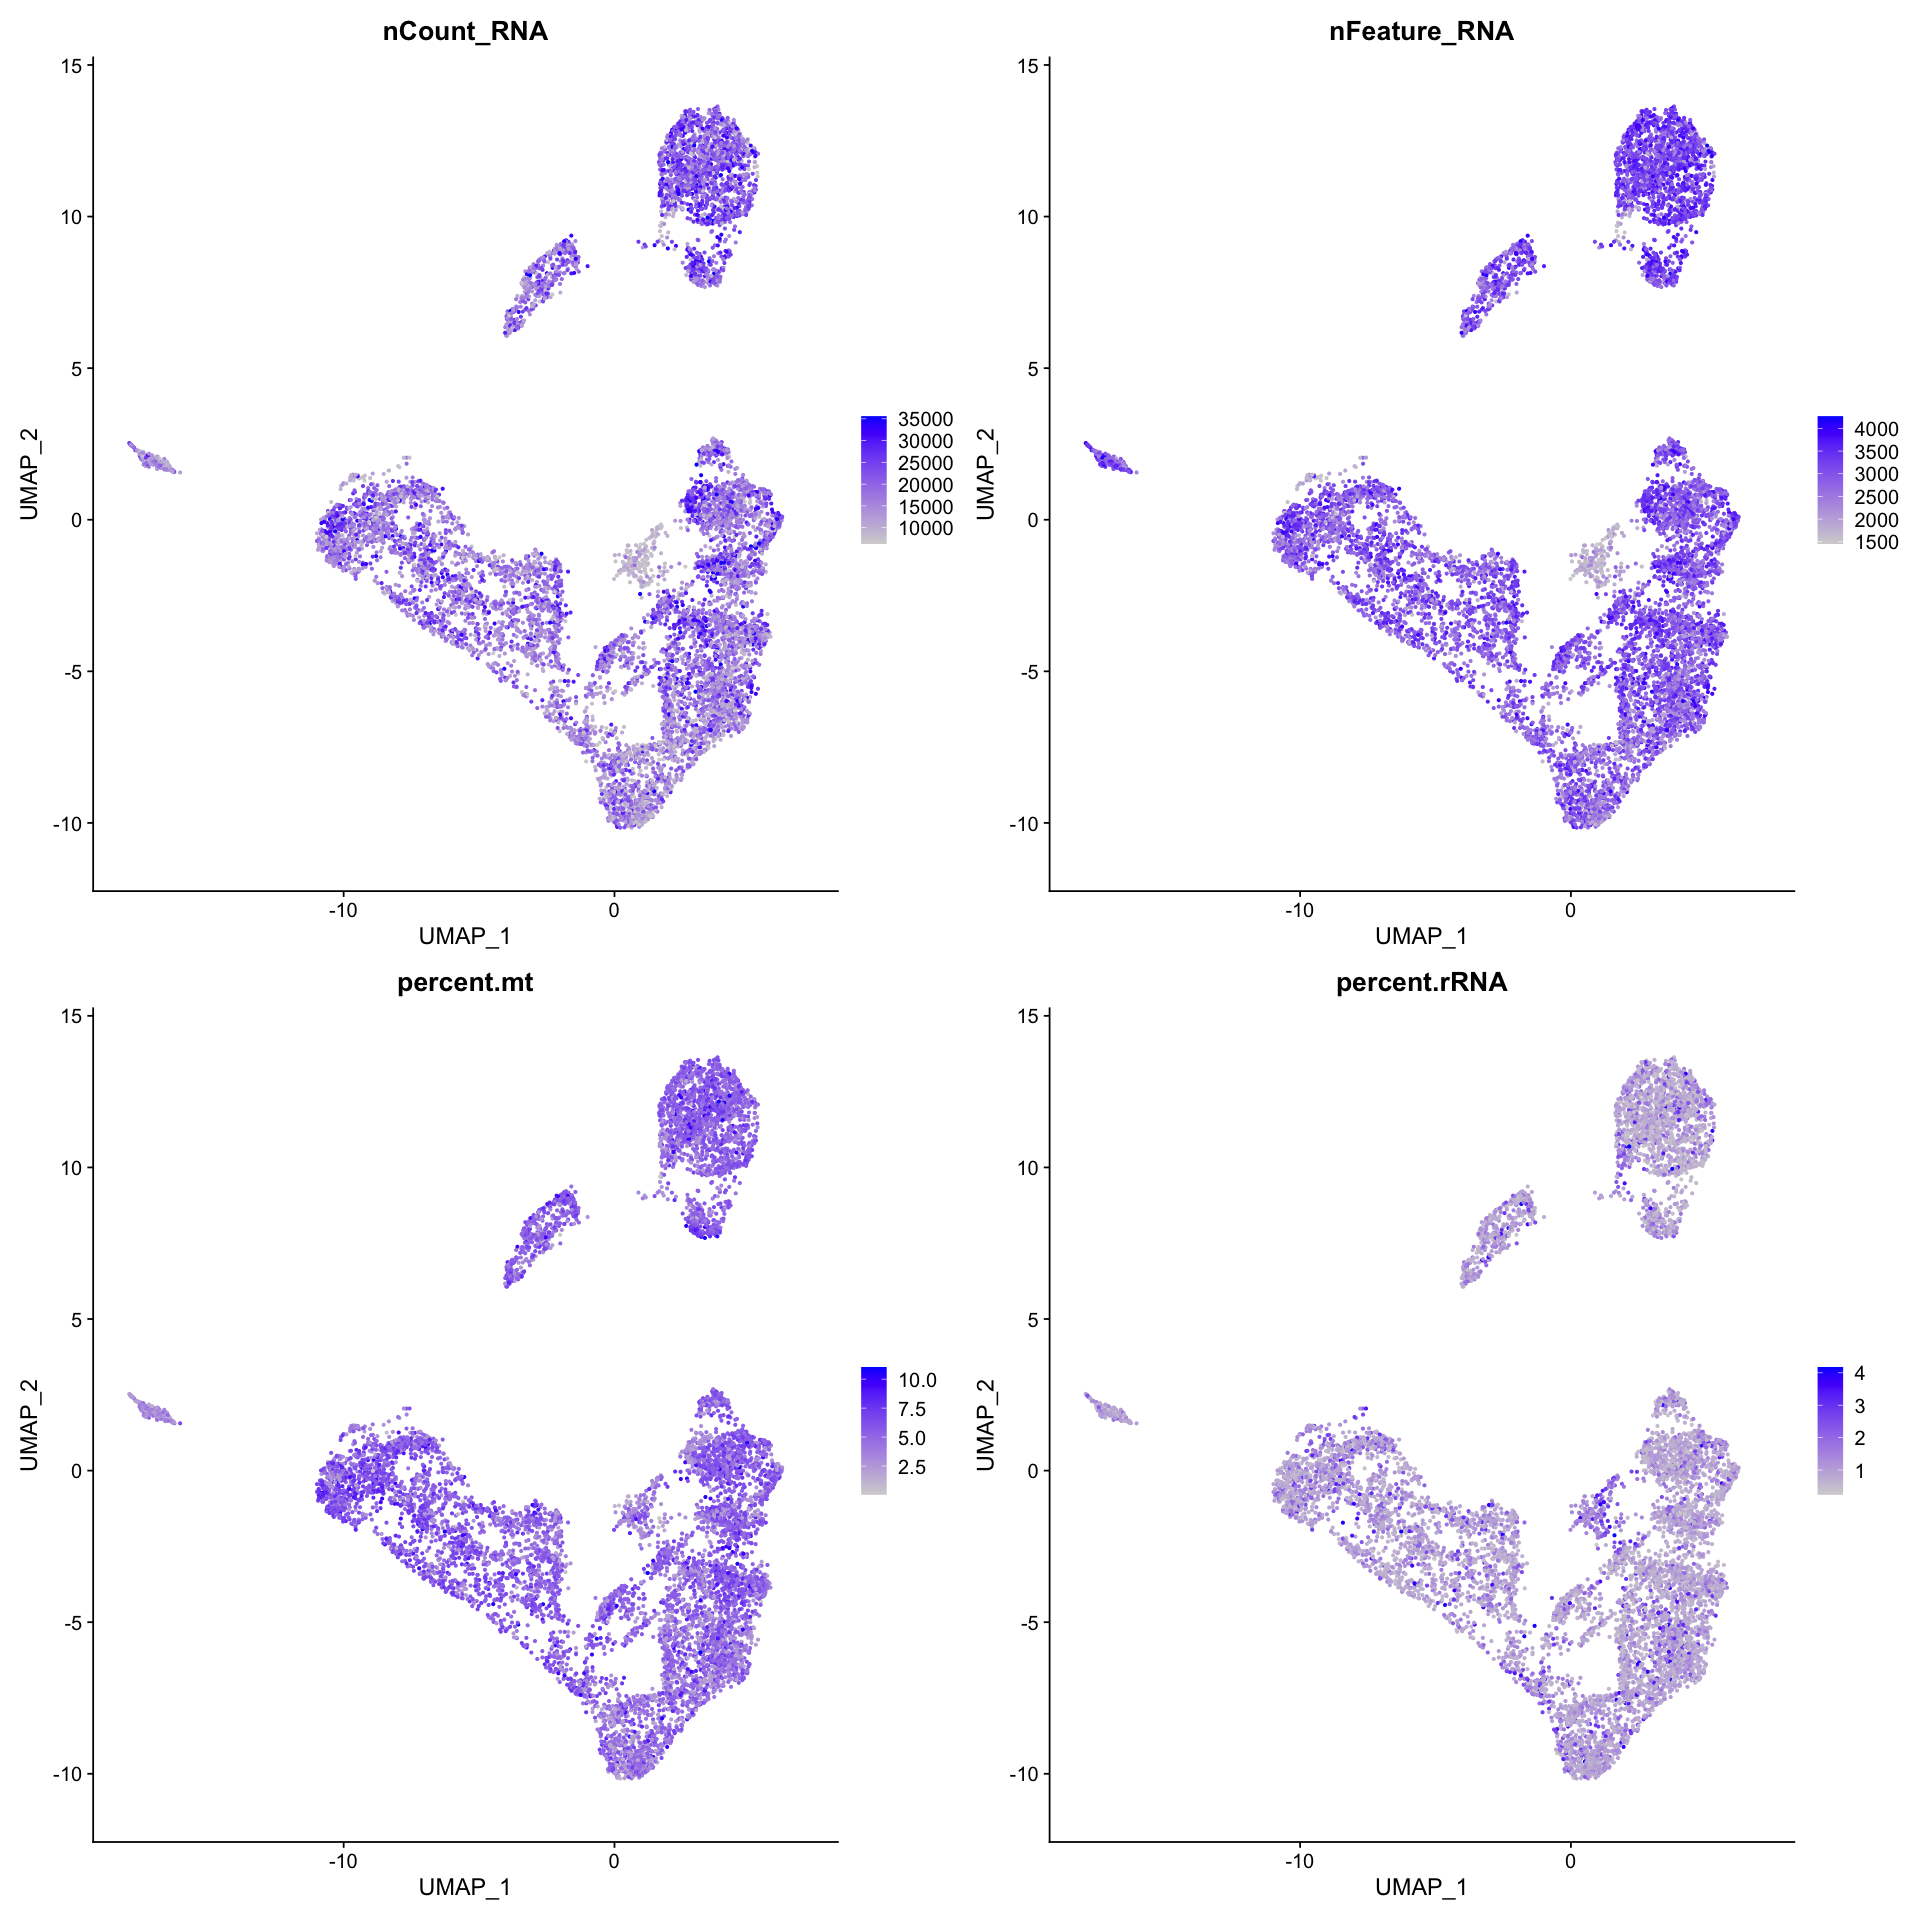

In [14]:
options(repr.plot.width=16, repr.plot.height=16)
FeaturePlot(seu_HQC, reduction = "umap", features = c("nCount_RNA", "nFeature_RNA", 
                               "percent.mt", "percent.rRNA"), pt.size = 0.5,  ncol = 2)

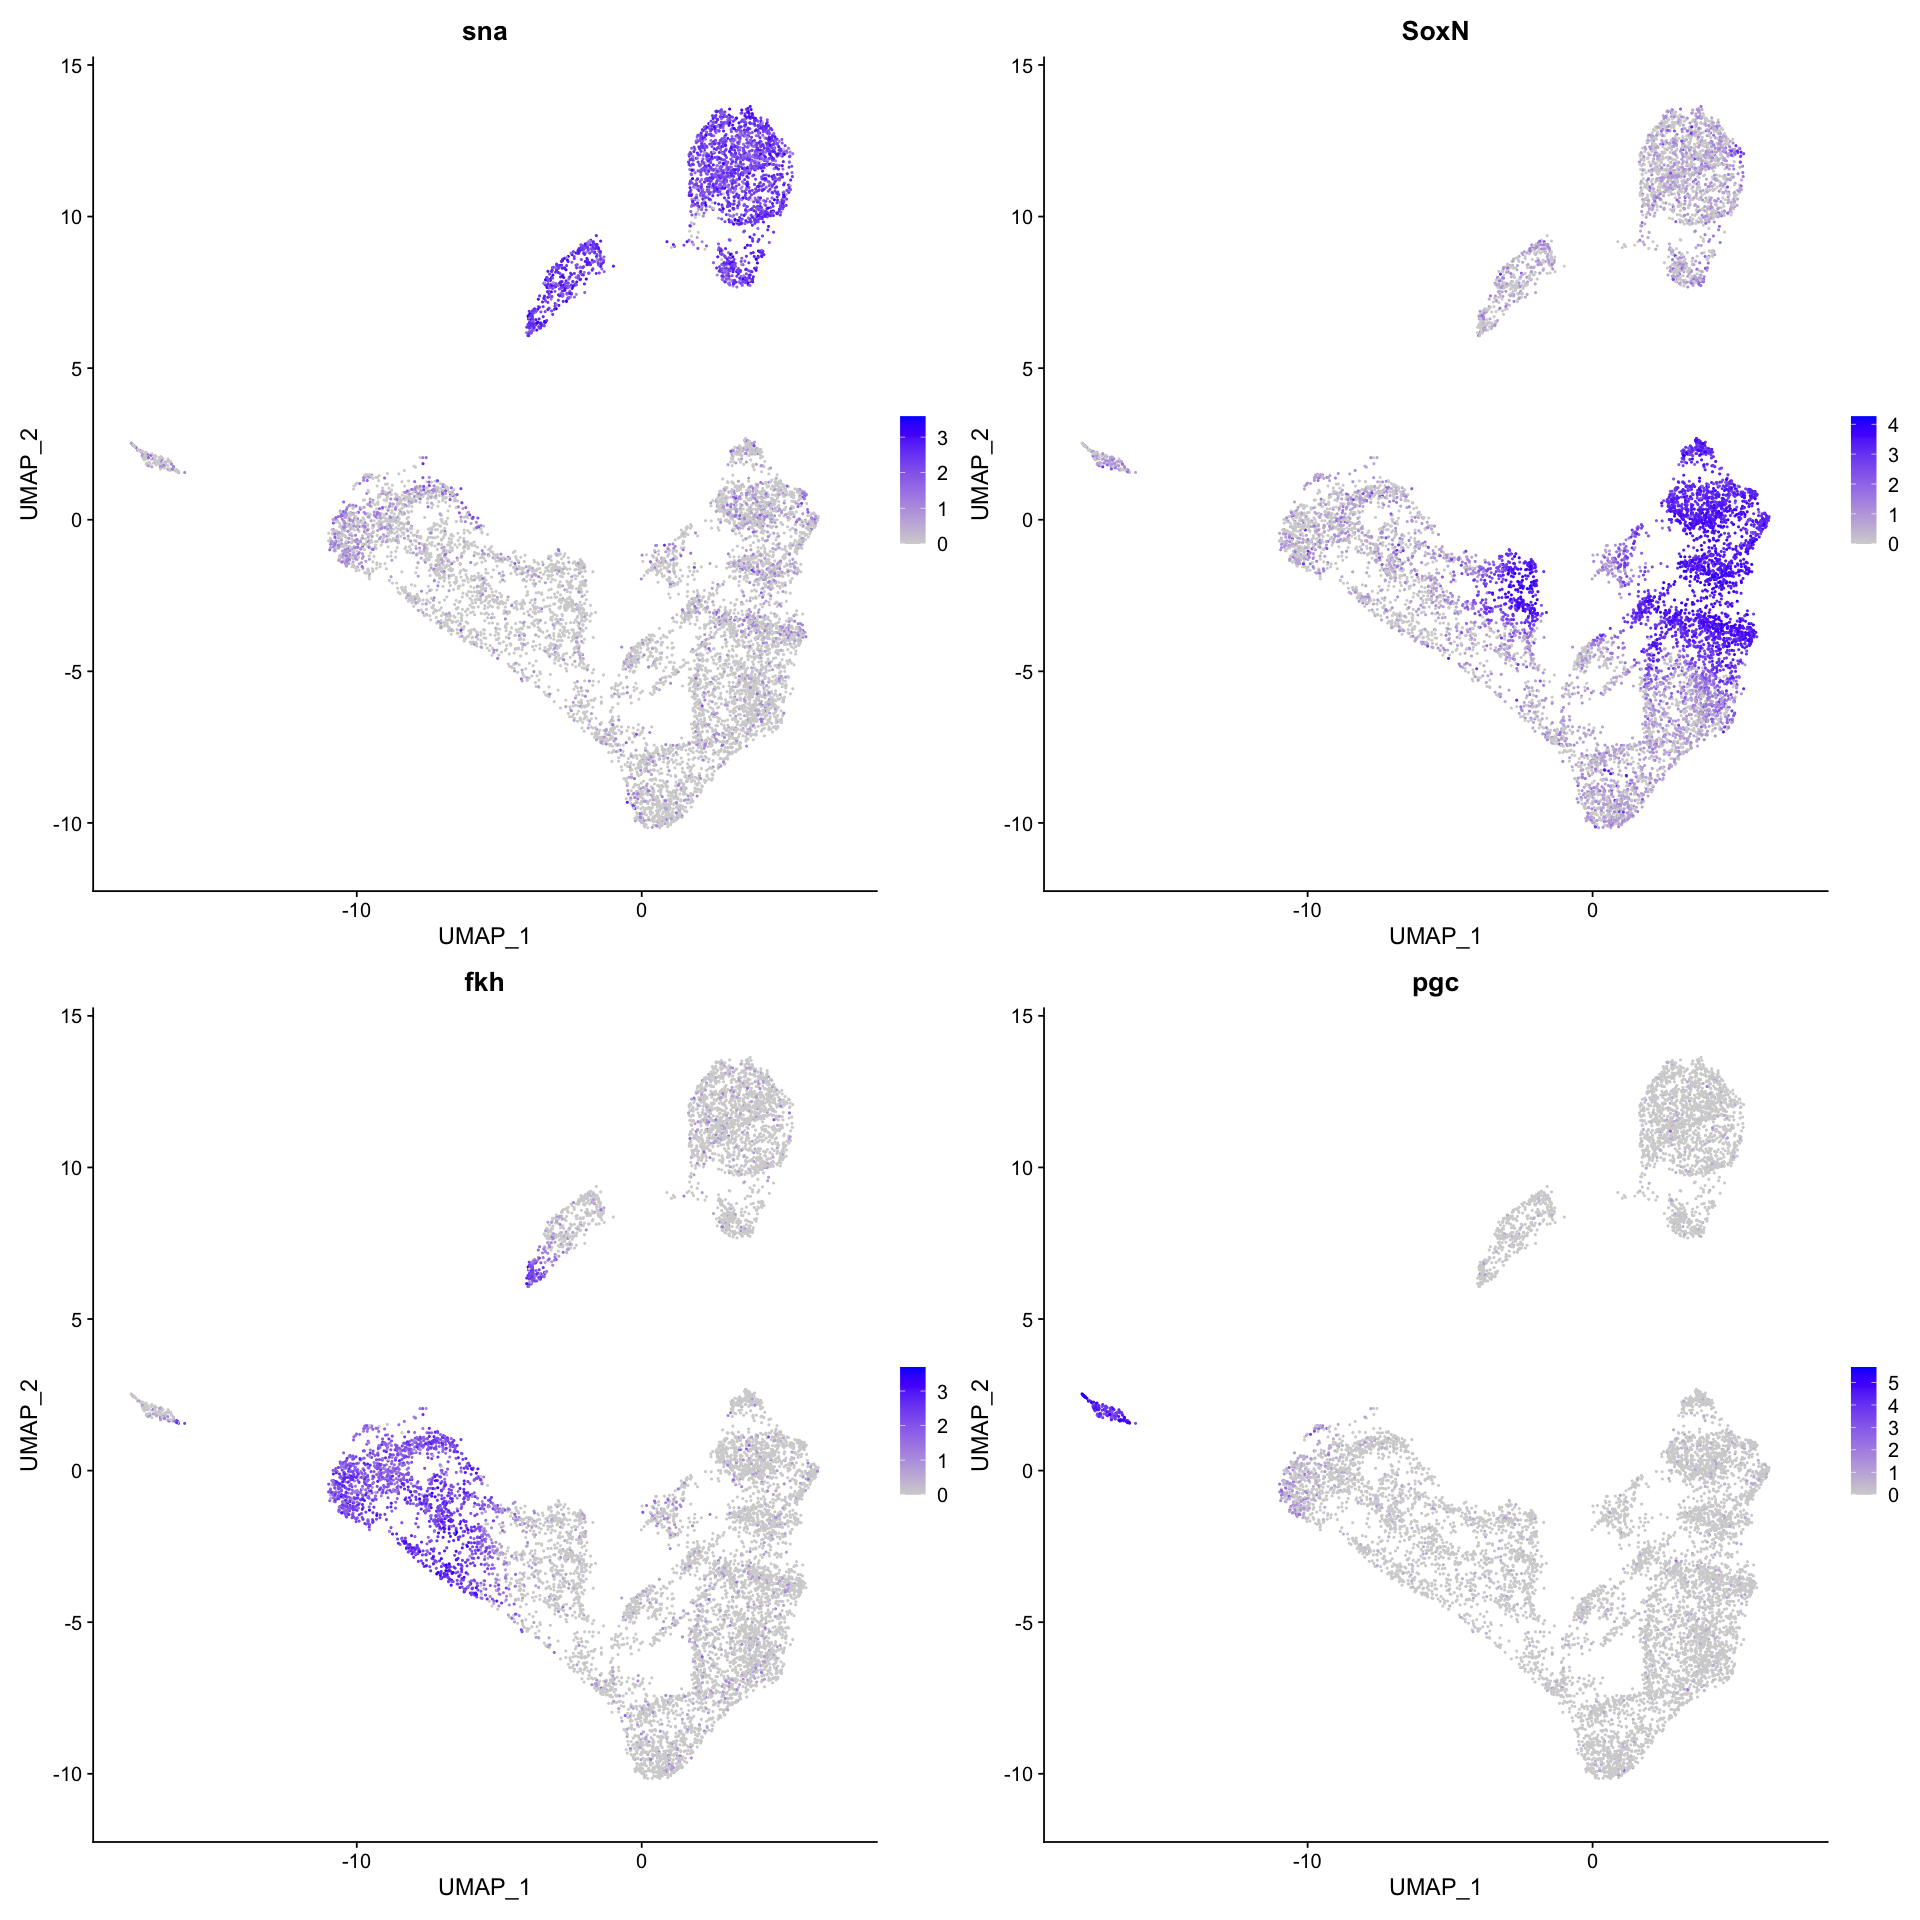

In [15]:
#Major marker genes of each germ layer
options(repr.plot.width=16, repr.plot.height=16)
FeaturePlot(seu_HQC, reduction = "umap", features = c("sna","SoxN", "fkh", "pgc"), pt.size = 0.2,  ncol = 2)

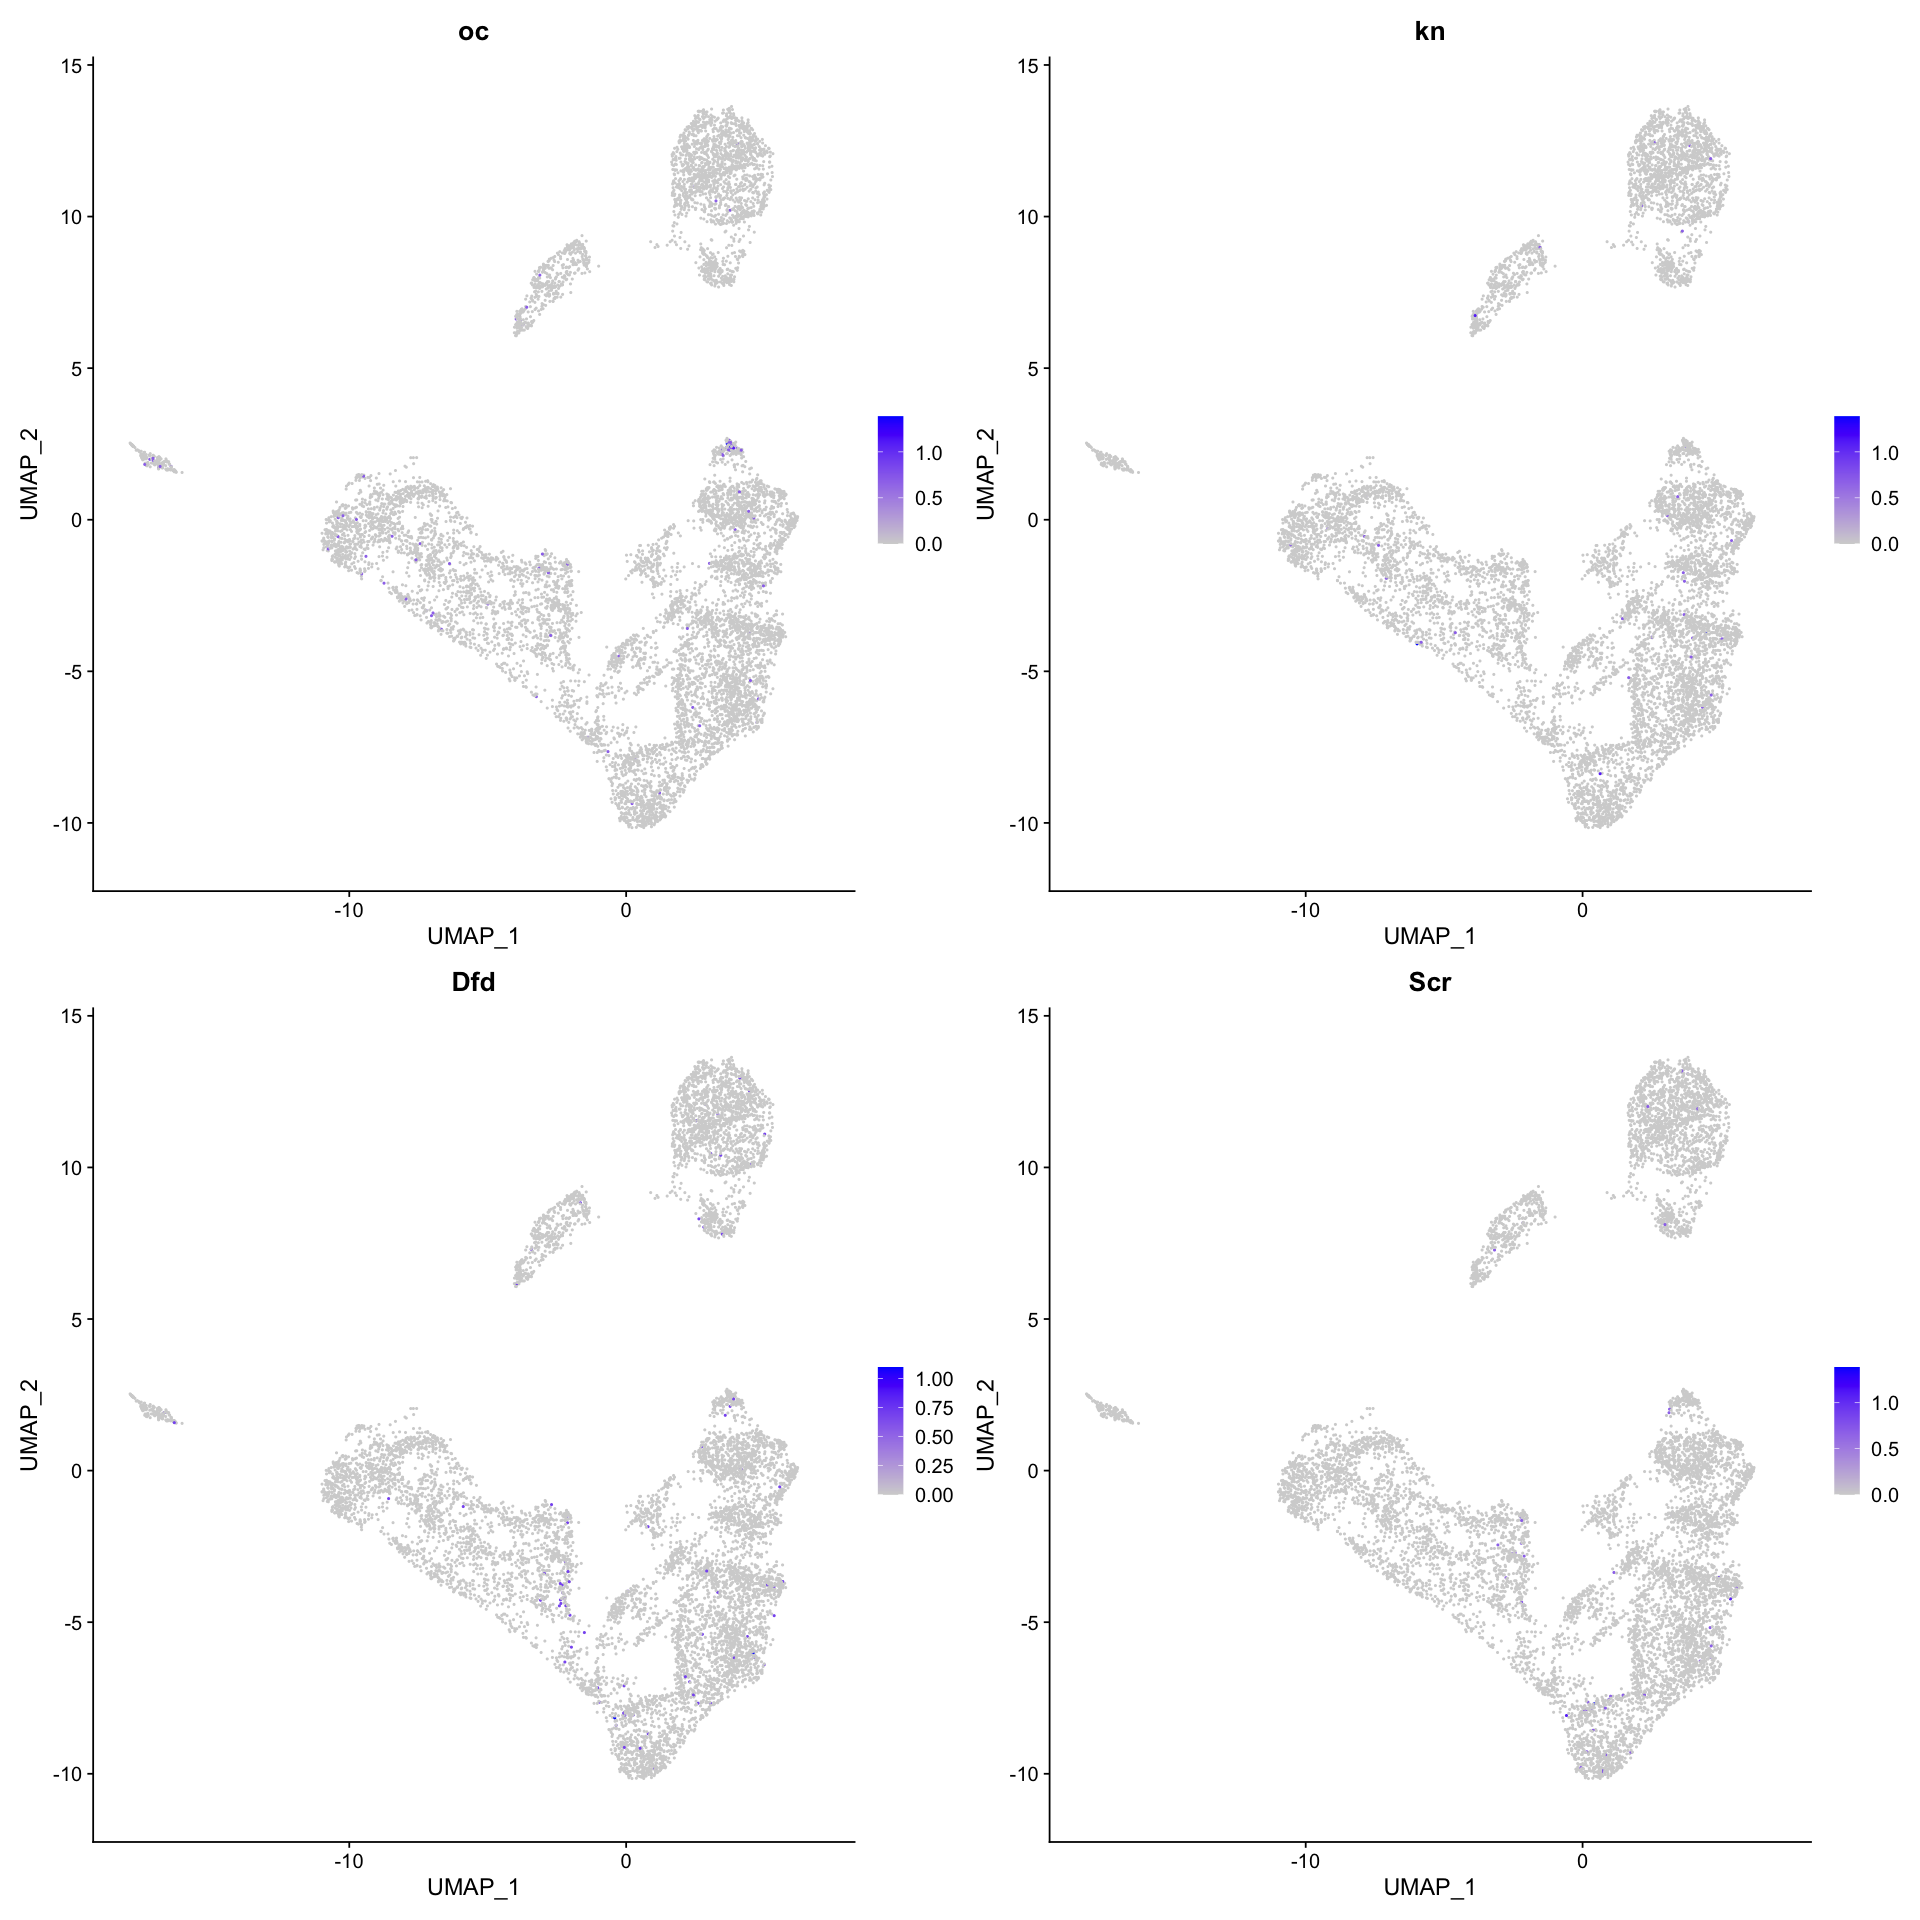

In [16]:
#Major marker genes of anterior region
options(repr.plot.width=16, repr.plot.height=16)
FeaturePlot(seu_HQC, reduction = "umap", features = c("oc","kn", "Dfd", "Scr"), pt.size = 0.2,  ncol = 2)

In [17]:
head(FindMarkers(seu_HQC, ident.1 = "1", ident.2 = c("3", "8"), test.use = "MAST"), n=30)


 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>---------------------


 Completed [====================================>-------]  85% with 0 failures

 Completed [=====================================>------]  86% with 0 failures

 Completed [=====================================>------]  87% with 0 failures

 Completed [=====================================>------]  88% with 0 failures

 Completed [======================================>-----]  88% with 0 failures

 Completed [======================================>-----]  89% with 0 failures

 Completed [=======================================>----]  90% with 0 failures

 Completed [=======================================>----]  91% with 0 failures

 Completed [=======================================>----]  92% with 0 failures

 Completed [========================================>---]  92% with 0 failures

 Completed [========================================>---]  93% with 0 failures

 Completed [========================================>---]  94% with 0 failures

 Completed [===========================


 Completed [===============================>------------]  74% with 0 failures

 Completed [================================>-----------]  74% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [================================>-----------]  76% with 0 failures

 Completed [=================================>----------]  76% with 0 failures

 Completed [=================================>----------]  77% with 0 failures

 Completed [=================================>----------]  78% with 0 failures

 Completed [==================================>---------]  79% with 0 failures

 Completed [==================================>---------]  80% with 0 failures

 Completed [==================================>---------]  81% with 0 failures

 Completed [===================================>--------]  81% with 0 failures

 Completed [===================================>--------]  82% with 0 failures

 Completed [===========================

p_val         avg_logFC  pct.1 pct.2 p_val_adj    
cv-2               0.000000e+00  1.9227416 0.989 0.157  0.000000e+00
dpp                0.000000e+00  1.8034787 0.959 0.085  0.000000e+00
pnr                0.000000e+00  1.2832586 0.844 0.064  0.000000e+00
shn                0.000000e+00  1.1673708 0.987 0.637  0.000000e+00
sca                0.000000e+00 -1.3544622 0.851 1.000  0.000000e+00
brk                0.000000e+00 -1.4145919 0.122 0.931  0.000000e+00
SoxN               0.000000e+00 -1.9650822 0.680 1.000  0.000000e+00
D                  0.000000e+00 -2.1237903 0.364 0.991  0.000000e+00
sog                0.000000e+00 -2.9151229 0.479 0.998  0.000000e+00
CG45263           1.976263e-323  1.5506353 0.893 0.188 2.267564e-319
CG43355-sala      2.657968e-281 -0.7887203 1.000 1.000 3.049752e-277
CG17724-Kdm4B-seq 3.268593e-279 -0.9087465 0.928 0.998 3.750384e-275
Atx-1             2.333970e-272  1.1791537 1.000 0.855 2.677997e-268
bbg               1.689599e-271  1.0678992 0.973 0.581 1.938646e-267
CG10011           1.061257e-263  0.9665724 0.993 0.820 1.217687e-259
ths               7.281217e-255 -1.0439163 0.632 0.991 8.354468e-251
mirr              5.731727e-247  1.7634749 0.822 0.253 6.576584e-243
CG12420           7.480136e-243  0.9957773 0.970 0.675 8.582708e-239
Tet               1.930423e-232 -0.7240466 0.997 1.000 2.214968e-228
RapGAP1           3.800218e-227  0.8474351 0.995 0.884 4.360370e-223
esg               4.049599e-222 -1.1891405 0.343 0.874 4.646510e-218
Cys               2.894481e-221 -0.7617680 1.000 1.000 3.321128e-217
pnt               4.065669e-211 -1.2210093 0.431 0.855 4.664949e-207
Ama               5.090204e-211  0.7435254 1.000 0.989 5.840500e-207
Nrt               5.109705e-208  0.7528033 1.000 0.994 5.862875e-204
net               9.160017e-204  1.0167937 0.673 0.094 1.051020e-199
tkv               2.065167e-194 -0.9128078 0.205 0.794 2.369573e-190
pros              6.886399e-194 -0.9433277 0.463 0.889 7.901454e-190
psq               3.420820e-188  0.6127521 1.000 0.992 3.925048e-184
DNaseII           2.225422e-185  0.8912065 0.954 0.633 2.553449e-181

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



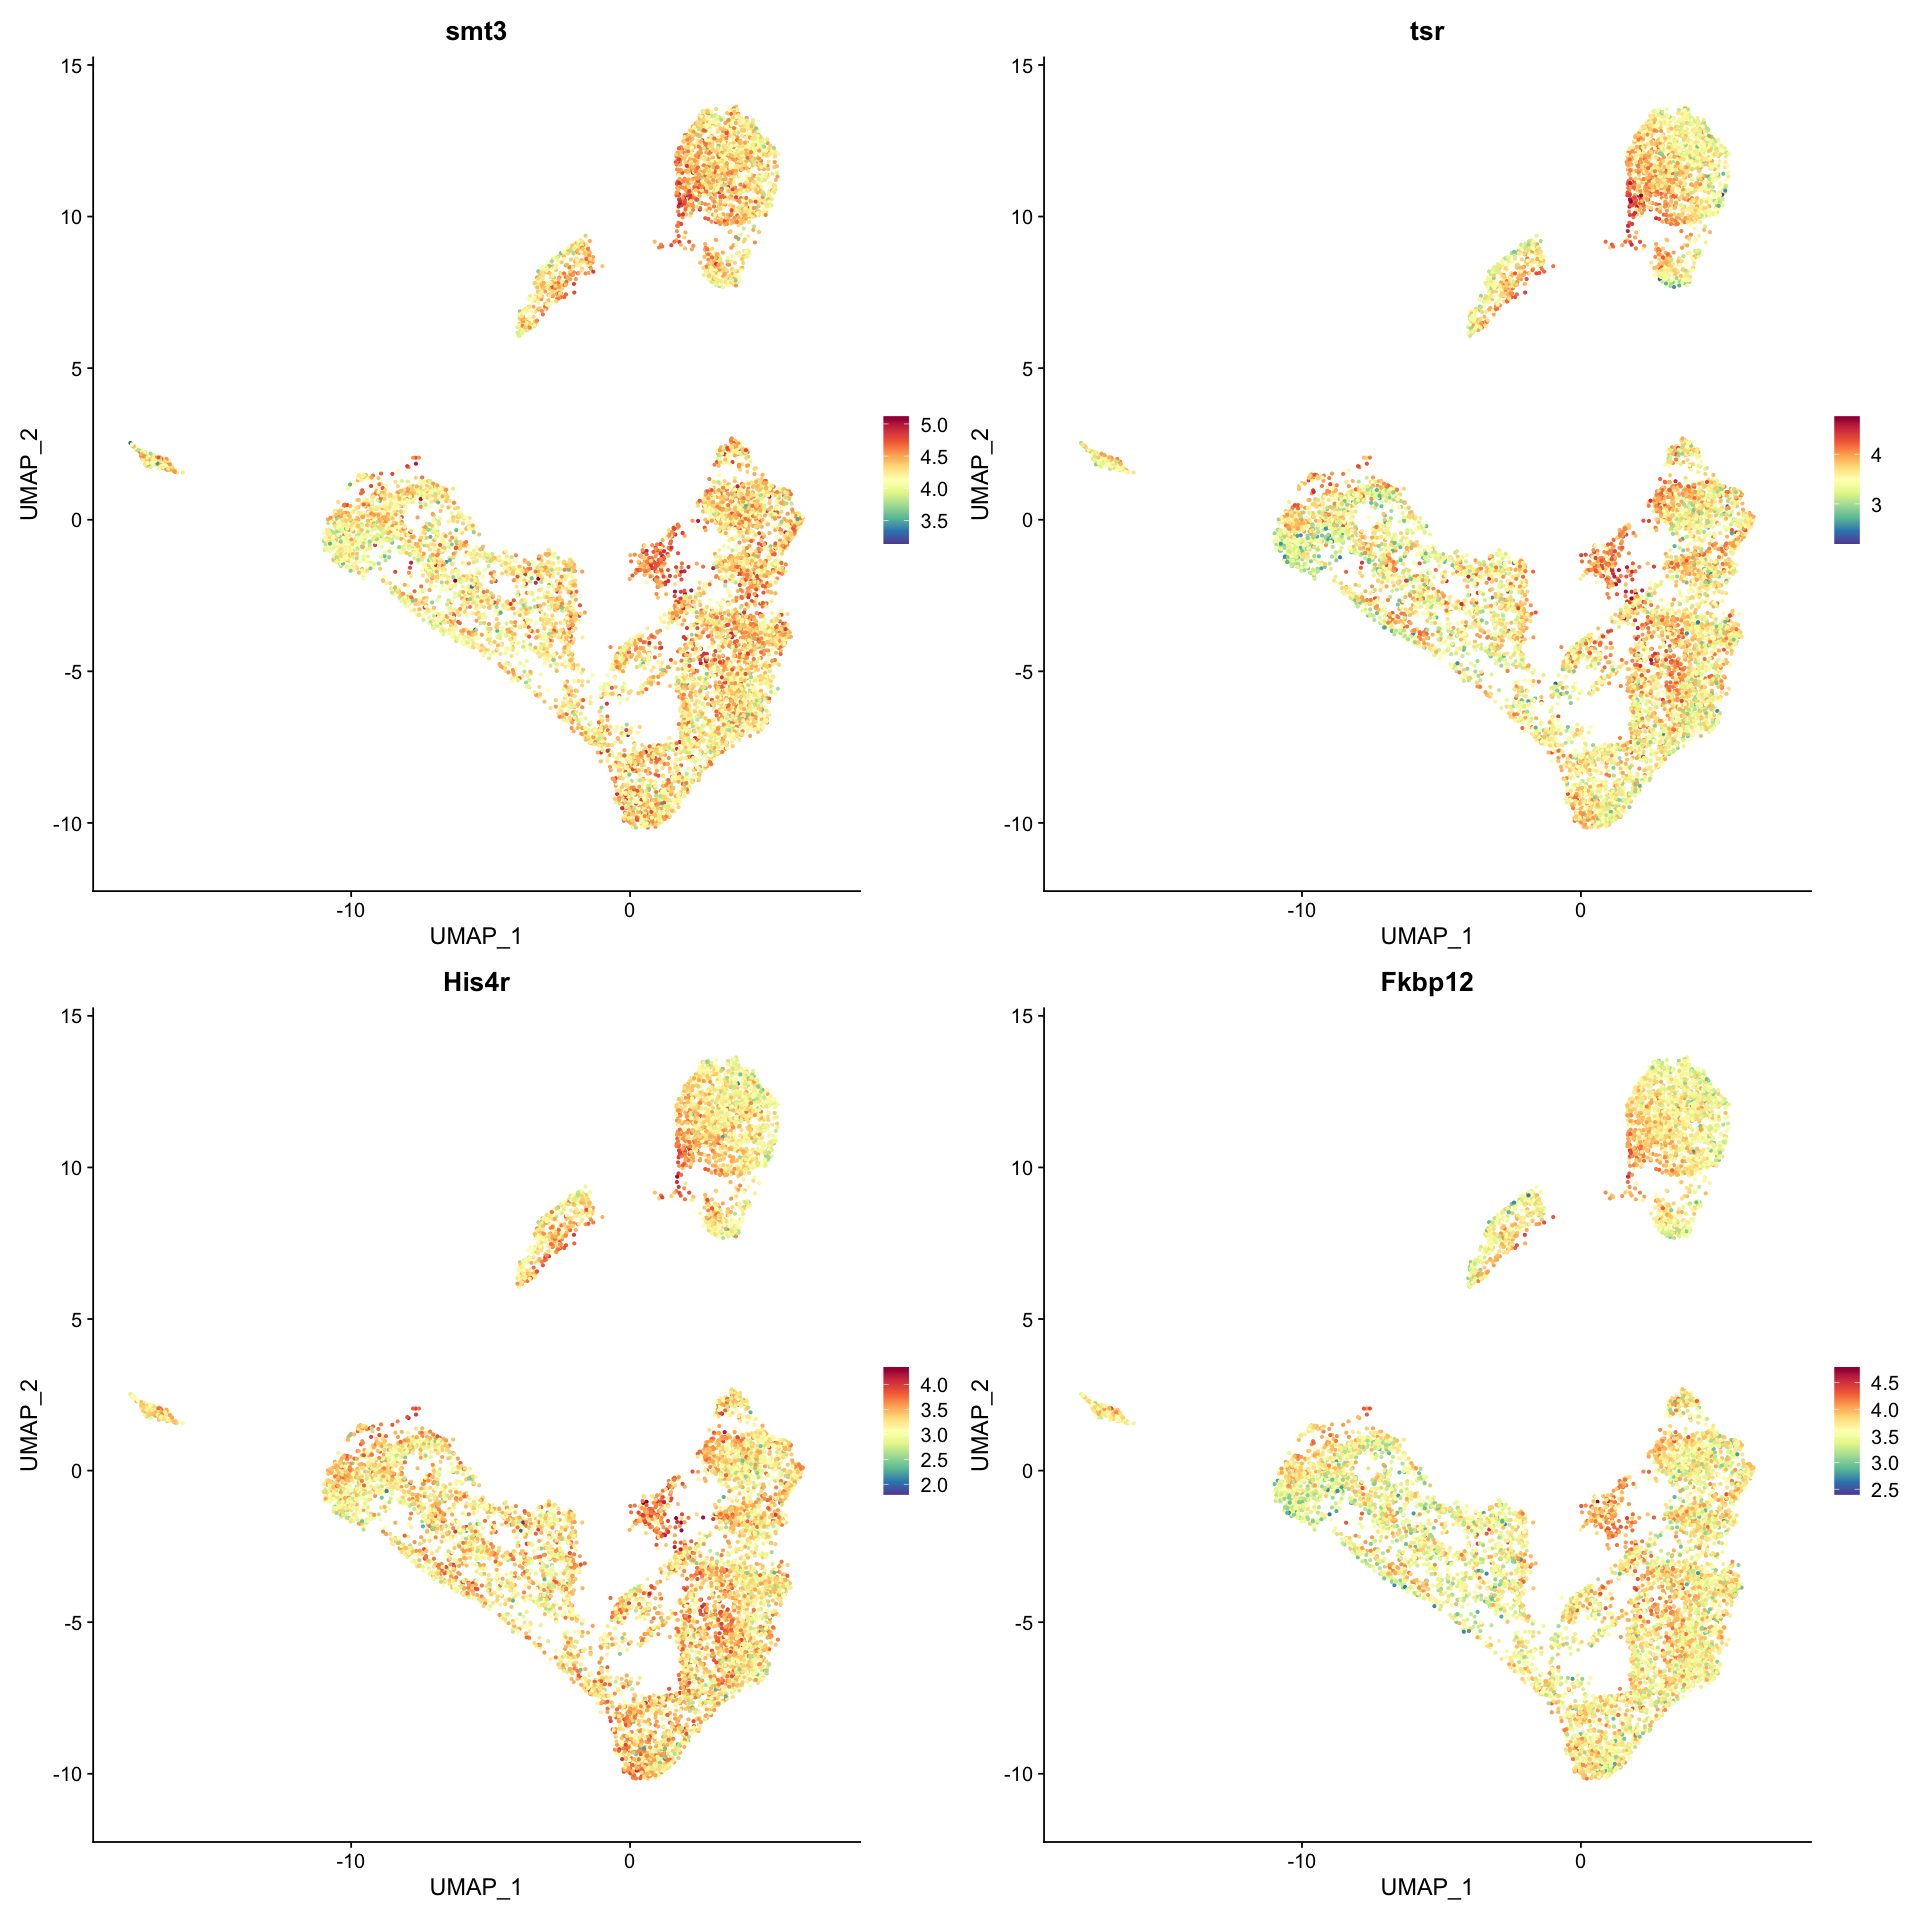

In [18]:
options(repr.plot.width=16, repr.plot.height=16)
FeaturePlot(seu_HQC, reduction = "umap", features = c("smt3", "tsr", "His4r", "Fkbp12"), pt.size = 0.5,  ncol = 2) & 
  scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "Spectral")))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



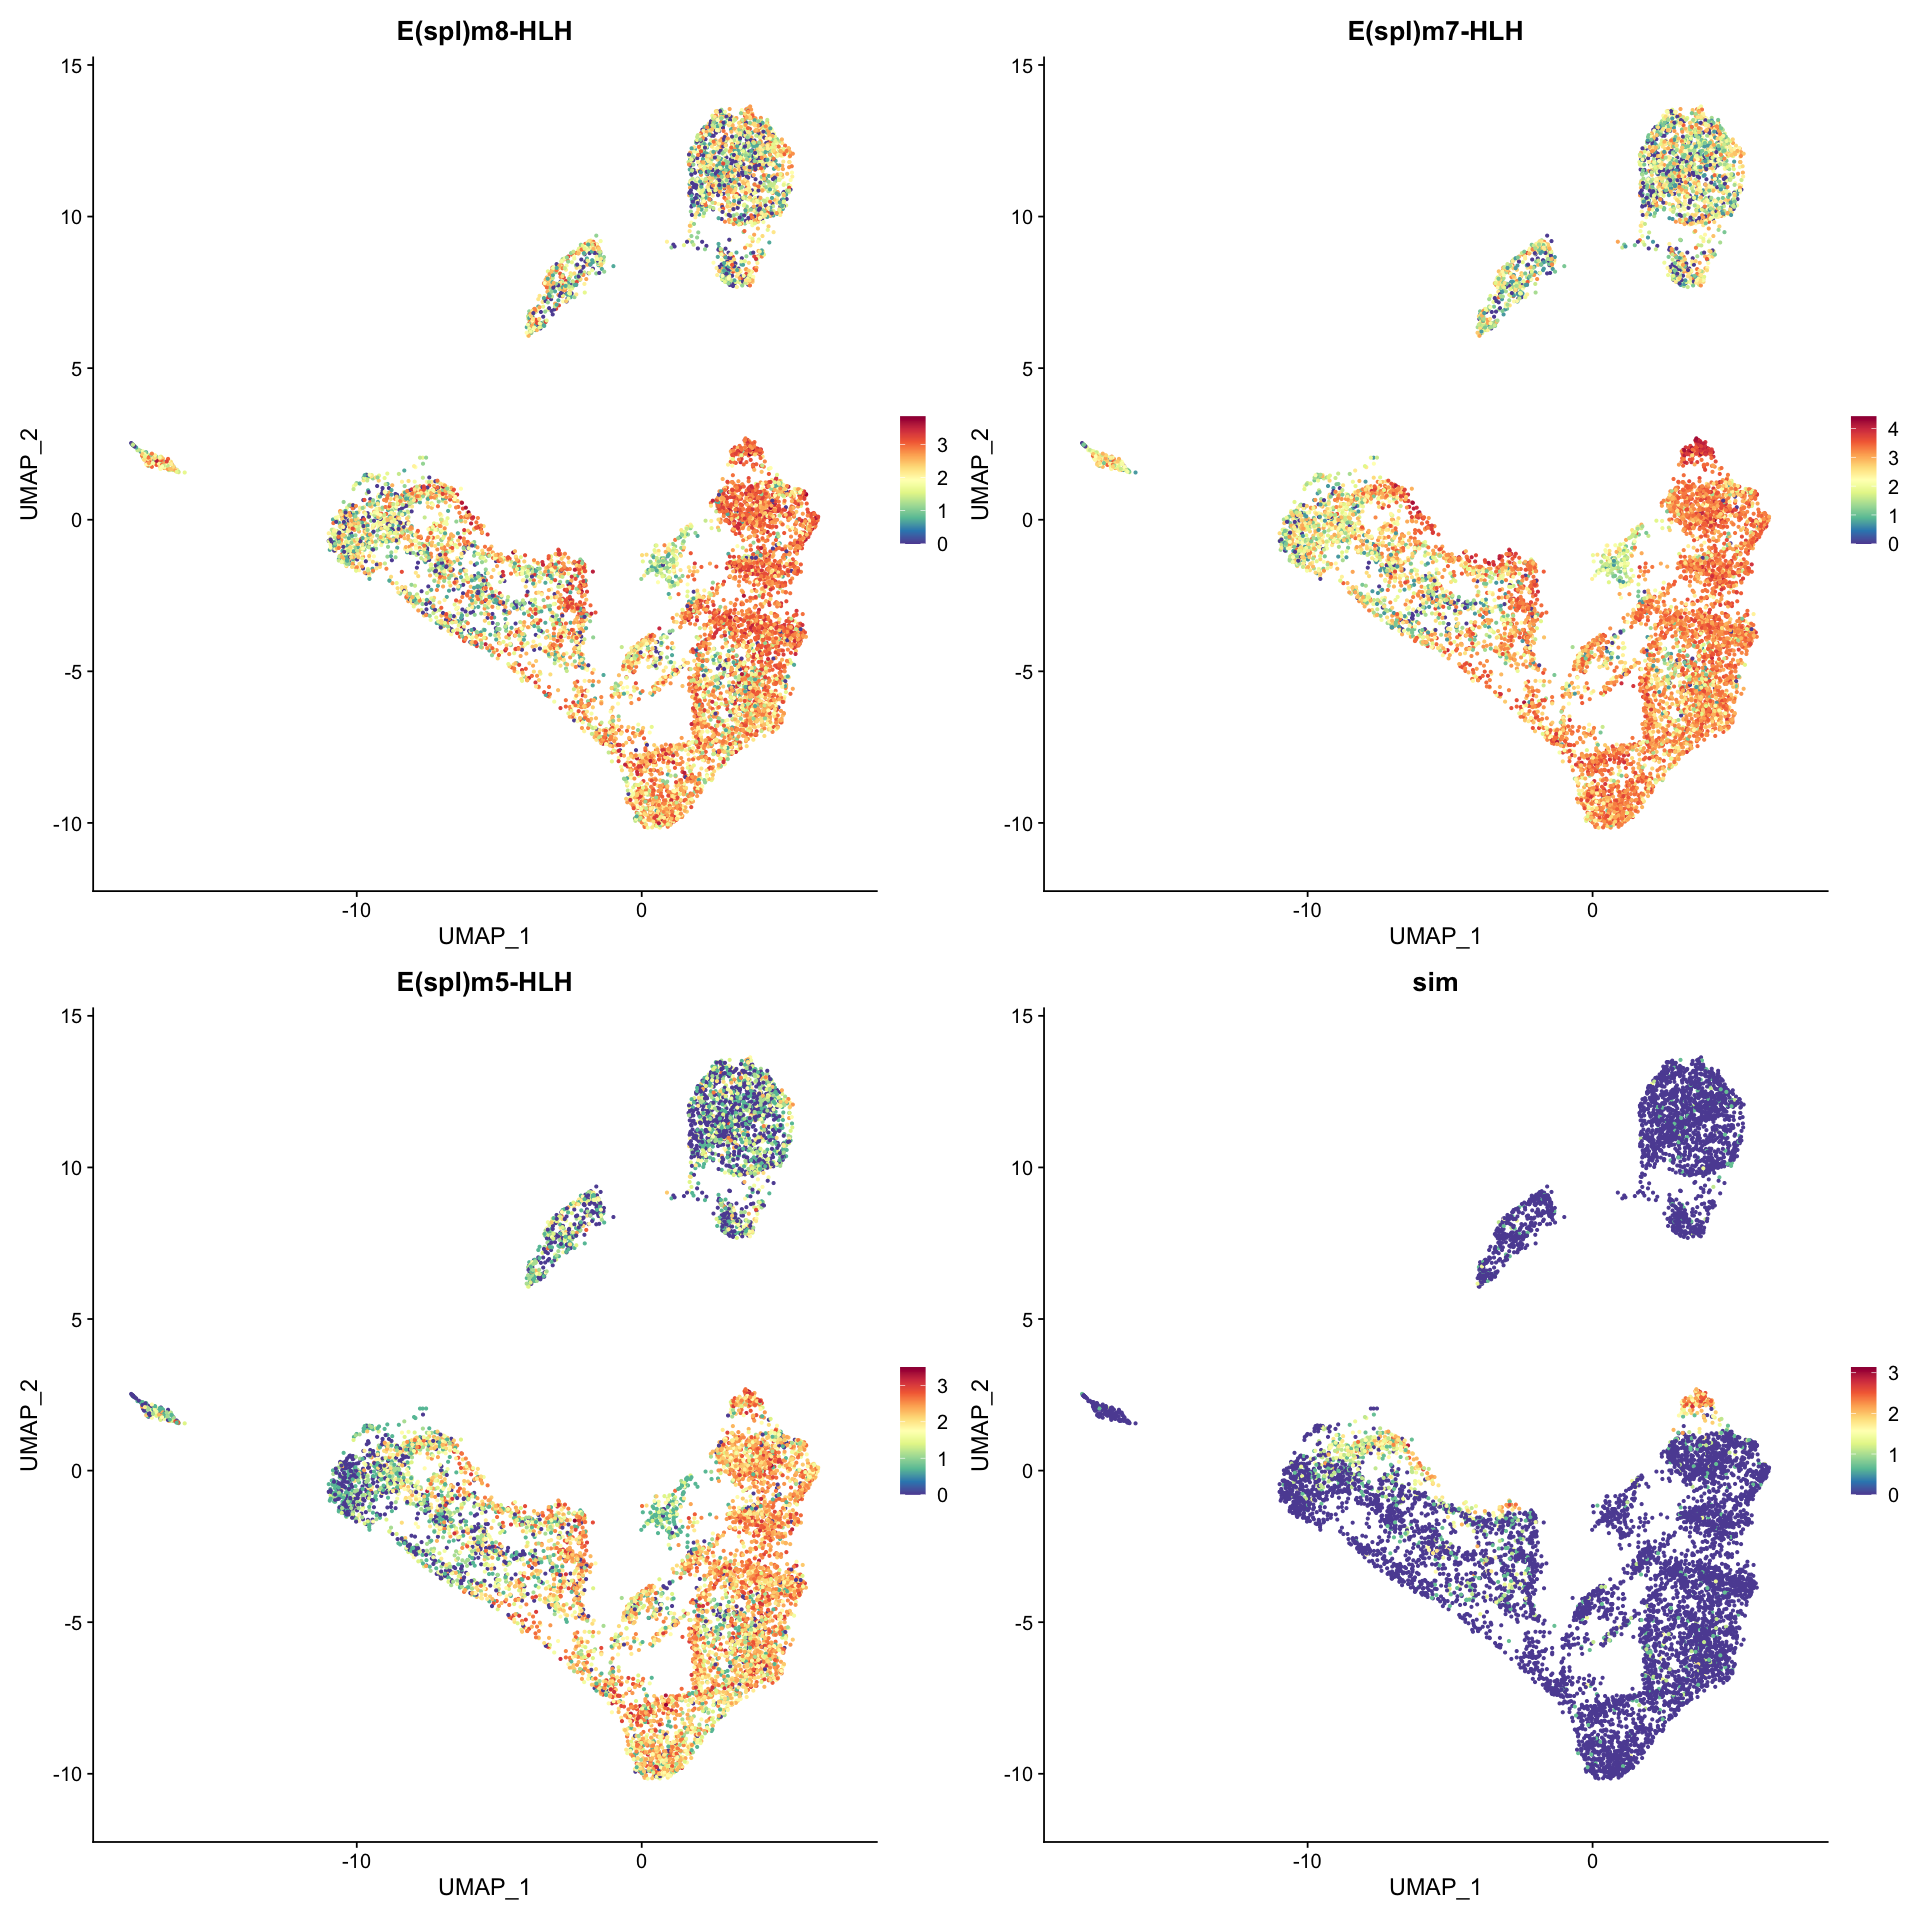

In [19]:
options(repr.plot.width=16, repr.plot.height=16)
FeaturePlot(seu_HQC, reduction = "umap", features = c("E(spl)m8-HLH", "E(spl)m7-HLH", "E(spl)m5-HLH", "sim"), pt.size = 0.5,  ncol = 2) & 
  scale_colour_gradientn(colours = rev(brewer.pal(n = 11, name = "Spectral")))

## Cluster annotation

In [20]:
manual_ID <- as.data.frame(seu_HQC$seurat_clusters)
colnames(manual_ID) <- c('manual_ID')
head(manual_ID)

manual_ID$manual_ID <- dplyr::recode(manual_ID$manual_ID, 
                                        "0" = "Trunk_mesoderm",
                                        "1" = "Dorsal_ectoderm_even",
                                        "2" = "Posterior_midgut",
                                        "3" = "Medial_neuroectoderm",
                                        "4" = "Amnioserosa",
                                        "5" = "Ectoderm_PS14",
                                        "6" = "Lateral_neuroectoderm",
                                        "7" = "Hindgut",
                                        "8" = "Intermediate_neuroectoderm",
                                        "9" = "Posterior_mesoderm",
                                        "10" = "Dorsal_ectoderm_odd",
                                        "11" = "tsr_high",
                                        "12" = "Ectoderm_PS13",
                                        "13" = "Dorsal_hindgut",
                                        "14" = "Posterior_amnioserosa",
                                        "15" = "Mesoderm_PS13",
                                        "16" = "Midline_cells",
                                        "17" = "Pole_cells"
                                     )
head(manual_ID)

manual_ID
AAACCCAAGTGGTTCT 0        
AAACCCACAAGACCTT 4        
AAACCCACATGGAATA 6        
AAACCCAGTTGTGGAG 0        
AAACCCATCACAGAGG 2        
AAACCCATCTGGGTCG 3

manual_ID            
AAACCCAAGTGGTTCT Trunk_mesoderm       
AAACCCACAAGACCTT Amnioserosa          
AAACCCACATGGAATA Lateral_neuroectoderm
AAACCCAGTTGTGGAG Trunk_mesoderm       
AAACCCATCACAGAGG Posterior_midgut     
AAACCCATCTGGGTCG Medial_neuroectoderm

In [21]:
seu_HQC$annotated_seurat_clusters <- manual_ID$manual_ID

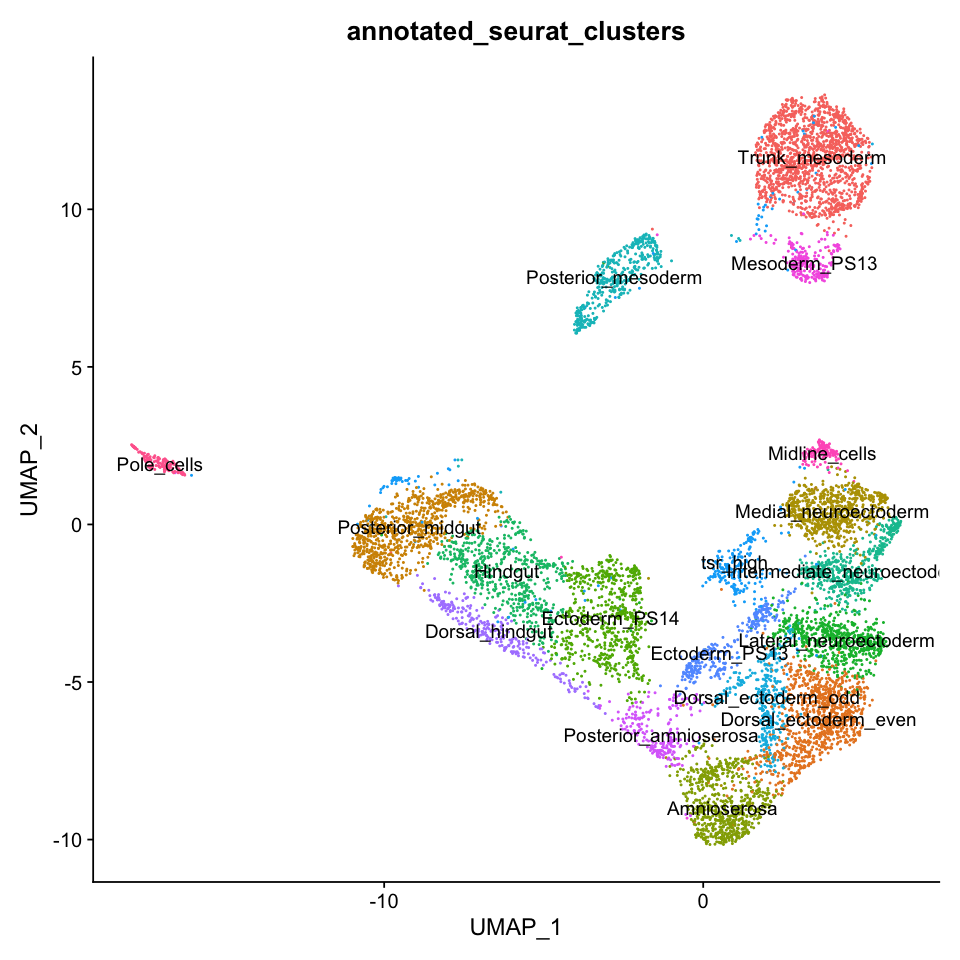

In [22]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu_HQC, reduction =  "umap", label = TRUE, group.by = 'annotated_seurat_clusters') + NoLegend()

In [23]:
write.table(manual_ID, 
            file="./manualID_with_stressedcell.txt",sep="\t",col.names=T,row.names=T,quote=F)

In [24]:
saveRDS(seu_HQC, file = "../../data/seurat_object/bcdRNAi/seu_HQC_bcdRNAi.obj")

In [25]:
write.table(all.markers, file="./all.markers_with_stressedcell.txt",sep="\t",col.names=T,row.names=T,quote=F)

In [92]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/ja_JP.UTF-8

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] mclust_5.4.7                viridis_0.5.1              
 [3] viridisLite_0.3.0           corrr_0.4.3                
 [5] MAST_1.16.0                 SingleCellExperiment_1.12.0
 [7] SummarizedExperiment_1.20.0 Biobase_2.50.0             
 [9] GenomicRanges_1.42.0        GenomeInfoDb_1.26.2        
[11] IRanges_2.24.1              S4Vectors_0.28.1           
[13] BiocGenerics_0.36.0         MatrixGenerics_1.2.0       
[15] matrixStats_0.57.0          RColorBrewer_1